# Term Deposit Subscription Prediction

# Goal

Using the data collected from existing customers, build a model that will help the marketing
team identify potential customers who are relatively more likely to subscribe term deposit
and thus increase their hit ratio. 

## Attribute information:
  - Input variables 
    - Bank client data
        1. age: continuous feature
        2. job: type of job (management, technician, entrepreneur, blue-collar, etc.)
        3. marital: marital status (married, single, divorced)
        4. education: education level (primary, secondary, tertiary)
        5. default: has credit in default?
        6. housing: has housing loan?
        7. loan: has personal loan?
        8. balance in account
    - Related to previous contact
        9. contact: contact communication type
        10. month: last contact month of year
        11. day: last contact day of the month
        12. duration: last contact duration, in seconds*
    - Other attributes
        13. campaign: number of contacts performed during this campaign and for this
    - Client
        14. pdays: number of days that passed by after the client was last contacted from a
    - Previous campaign (-1 tells us the person has not been contacted or contact period is beyond 900 days)
        15. previous: number of times the client has been contacted before for the last
    - Campaign to subscribe term deposit
        16. poutcome: outcome of the previous marketing campaign
  - Output variable (desired target)
      17. Target: Tell us has the client subscribed a term deposit. (Yes, No)

# Import all necessary modules

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

from yellowbrick.classifier import ClassificationReport, ROCAUC

plt.style.use('ggplot')
pd.options.display.float_format = '{:,.2f}'.format
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Load and review data

In [2]:
df = pd.read_csv('bank-full.csv')

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


# EDA

## Univariate analysis

In [4]:
df.shape

(45211, 17)

In [5]:
df.isnull().values.any()

False

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  Target     45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [7]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,"45,211.00","45,211.00","45,211.00","45,211.00","45,211.00","45,211.00","45,211.00"
mean,40.94,"1,362.27",15.81,258.16,2.76,40.20,0.58
std,10.62,"3,044.77",8.32,257.53,3.10,100.13,2.30
min,18.00,"-8,019.00",1.00,0.00,1.00,-1.00,0.00
25%,33.00,72.00,8.00,103.00,1.00,-1.00,0.00
50%,39.00,448.00,16.00,180.00,2.00,-1.00,0.00
75%,48.00,"1,428.00",21.00,319.00,3.00,-1.00,0.00
max,95.00,"102,127.00",31.00,"4,918.00",63.00,871.00,275.00


In [8]:
df.nunique() # Number of unique values in a column

age            77
job            12
marital         3
education       4
default         2
balance      7168
housing         2
loan            2
contact         3
day            31
month          12
duration     1573
campaign       48
pdays         559
previous       41
poutcome        4
Target          2
dtype: int64

**Insights:**
- `default, housing, and loan are categorical with binary values indicating the existence of each category (yes/no)`
- `marital and education also have a fixed number of categories`

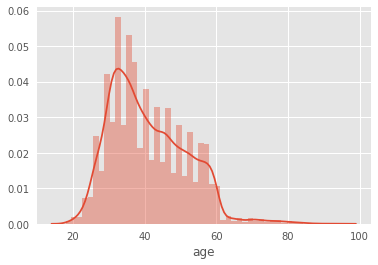

In [36]:
# distplot for age
sns.distplot(df['age'])
plt.show()

**Insights:**
- `the data is positively skewed, we can expect the mean age to be higher than the median`
- `the most frequent client age lies between 20-40 years`

In [10]:
for i in list(df.columns[df.dtypes=='object']):   
    print(df[i].value_counts(normalize=True))
    print()

blue-collar     0.22
management      0.21
technician      0.17
admin.          0.11
services        0.09
retired         0.05
self-employed   0.03
entrepreneur    0.03
unemployed      0.03
housemaid       0.03
student         0.02
unknown         0.01
Name: job, dtype: float64

married    0.60
single     0.28
divorced   0.12
Name: marital, dtype: float64

secondary   0.51
tertiary    0.29
primary     0.15
unknown     0.04
Name: education, dtype: float64

no    0.98
yes   0.02
Name: default, dtype: float64

yes   0.56
no    0.44
Name: housing, dtype: float64

no    0.84
yes   0.16
Name: loan, dtype: float64

cellular    0.65
unknown     0.29
telephone   0.06
Name: contact, dtype: float64

may   0.30
jul   0.15
aug   0.14
jun   0.12
nov   0.09
apr   0.06
feb   0.06
jan   0.03
oct   0.02
sep   0.01
mar   0.01
dec   0.00
Name: month, dtype: float64

unknown   0.82
failure   0.11
other     0.04
success   0.03
Name: poutcome, dtype: float64

no    0.88
yes   0.12
Name: Target, dtype: float64

**Insights:**
- `more clients fall into the blue-collar worker, married, and secondary education categories than the other categories`
- `56% of clients have a housing loan`
- `84% of clients do not have a personal loan`

## Multivariate analysis

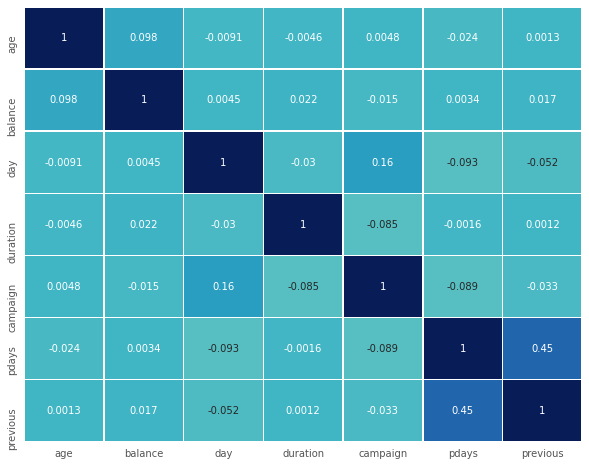

In [11]:
plt.figure(figsize=(10,8))

sns.heatmap(df.corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False,
            cmap="YlGnBu")

plt.show()

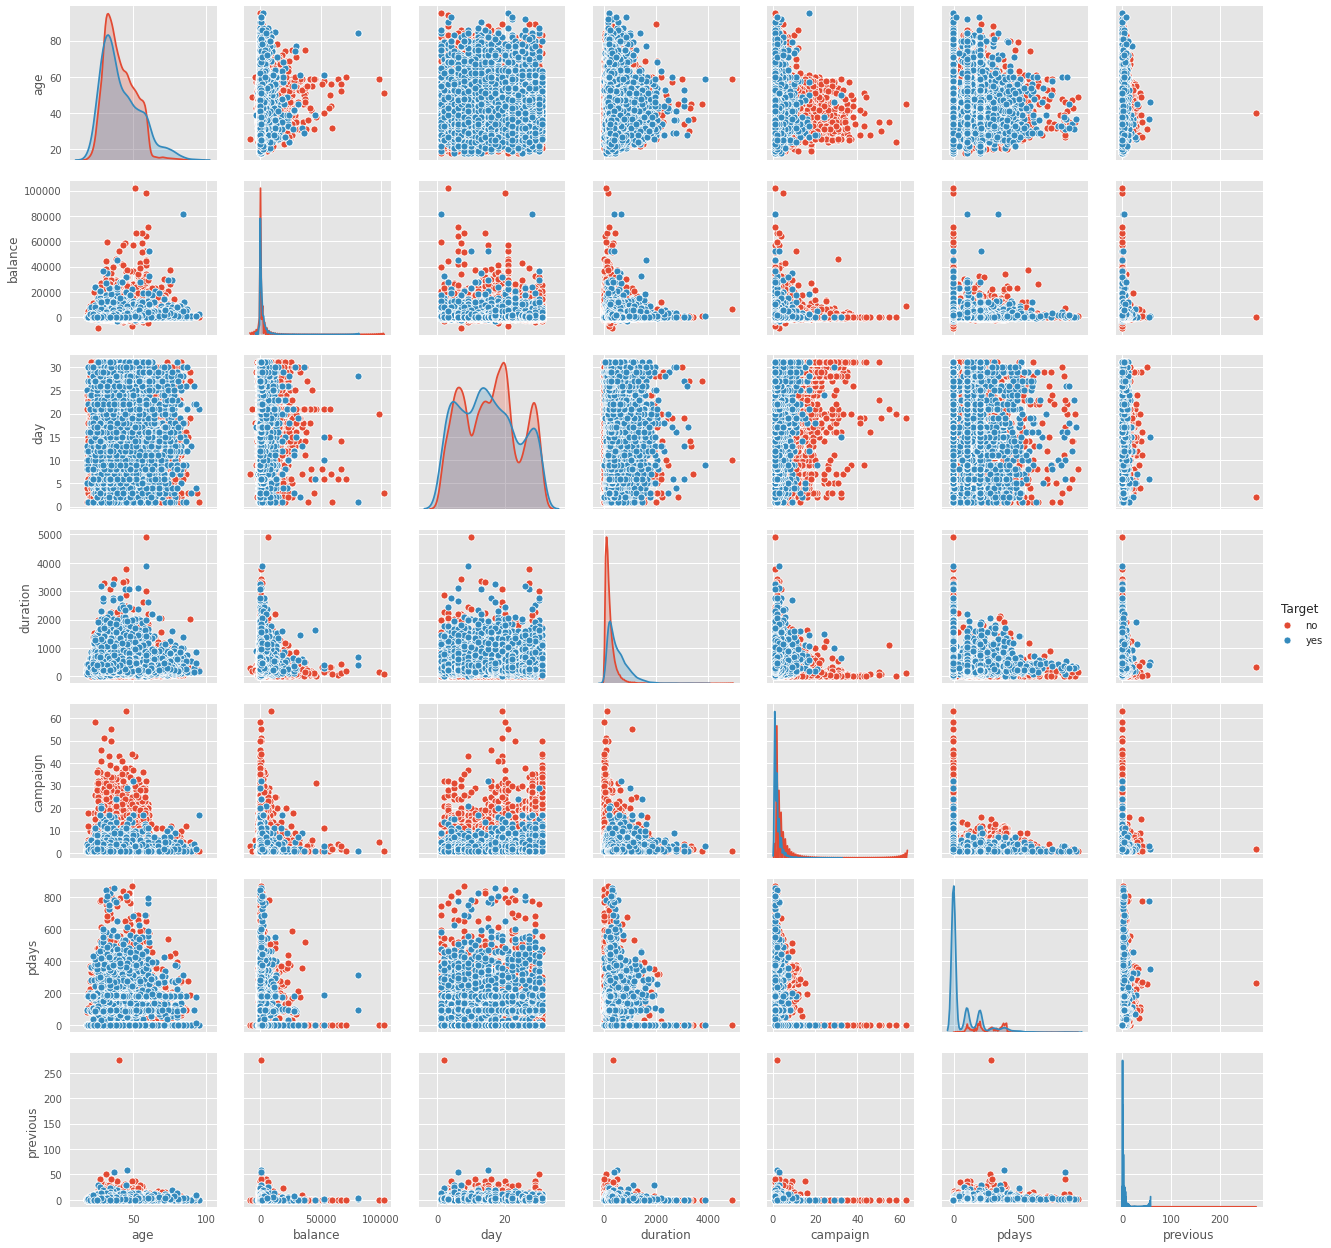

In [12]:
sns.pairplot(df, hue = 'Target')

In [13]:
df.groupby(['marital','education'])['Target'].value_counts()

marital   education  Target
divorced  primary    no          648
                     yes         104
          secondary  no         2524
                     yes         291
          tertiary   no         1268
                     yes         203
          unknown    no          145
                     yes          24
married   primary    no         4850
                     yes         396
          secondary  no        12466
                     yes        1304
          tertiary   no         6125
                     yes         913
          unknown    no         1018
                     yes         142
single    primary    no          762
                     yes          91
          secondary  no         5762
                     yes         855
          tertiary   no         3912
                     yes         880
          unknown    no          442
                     yes          86
Name: Target, dtype: int64

**Insights:**
- `When the client has subscribed a term deposit, regardless of education, they are most likely they are married.`
- `When the client has not subscribed a term deposit, regardless of marital status, they most likely have a secondary education.`

In [14]:
df.groupby(["Target"]).median()

,age,balance,day,duration,campaign,pdays,previous
Target,,,,,,,
no,39,417,16,164,2,-1,0
yes,38,733,15,426,2,-1,0


**Insights:**
- `No major difference in case of age with relation to target`
- `Median balance is higher for clients who subscribed a term deposit`

# Prepare the data

In [15]:
df.Target = df.Target.map(dict(yes=1, no=0))
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0


In [16]:
Y = df[['Target']]
X = df.drop('Target', axis=1)

In [17]:
# Convert categorical variables to dummy variables
X = pd.get_dummies(X)

In [18]:
# Split into training and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=11)
X_train.shape, X_test.shape

((31647, 51), (13564, 51))

# Create the model

In [19]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression

# Logistic Regression
# fit the model on train data
logreg = LogisticRegression(random_state=7)
logreg.fit(X_train, y_train)                    

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=7, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [20]:
y_predict = logreg.predict(X_test)              # Predicting the target variable on test data

In [21]:
## function to get confusion matrix in a proper format
def draw_cm( actual, predicted ):
    cm = confusion_matrix( actual, predicted)
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = [0,1] , yticklabels = [0,1] )
    plt.ylabel('Observed')
    plt.xlabel('Predicted')
    plt.show()

Training accuracy 0.9024868075962966

Testing accuracy 0.9003243880861103

Confusion Matrix


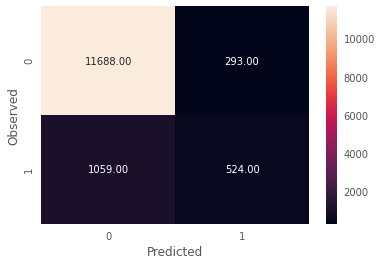

None

Recall: 0.3310170562223626

Precision: 0.6413708690330477

F1 Score: 0.43666666666666665

Roc Auc Score: 0.6532808342625877


In [22]:
print("Training accuracy",logreg.score(X_train,y_train))  
print()
print("Testing accuracy",logreg.score(X_test, y_test))
print()
print('Confusion Matrix')
print(draw_cm(y_test,y_predict))
print()
print("Recall:",recall_score(y_test,y_predict))
print()
print("Precision:",precision_score(y_test,y_predict))
print()
print("F1 Score:",f1_score(y_test,y_predict))
print()
print("Roc Auc Score:",roc_auc_score(y_test,y_predict))

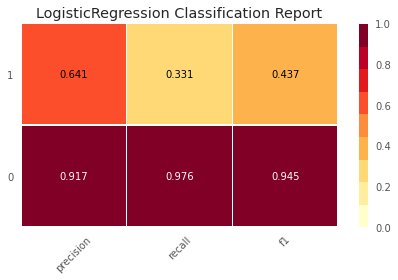

<AxesSubplot:title={'center':'LogisticRegression Classification Report'}>

In [35]:
viz = ClassificationReport(logreg)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

In [24]:
# Decision Tree

model_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [25]:
model_entropy.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [26]:
print("Train: %.2f" % model_entropy.score(X_train, y_train))  # performance on train data
print("Test: %.2f" % model_entropy.score(X_test, y_test))  # performance on test data

Train: 0.90
Test: 0.90


Training accuracy 0.9009700761525579

Testing accuracy 0.8984812739604836

Confusion Matrix


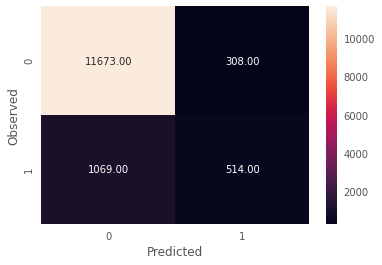

None

Recall: 0.32469993682880605

Precision: 0.6253041362530414

F1 Score: 0.4274428274428274

Roc Auc Score: 0.6494962834131509


In [27]:
y_predict = model_entropy.predict(X_test)

print("Training accuracy", model_entropy.score(X_train, y_train))  
print()
print("Testing accuracy", model_entropy.score(X_test, y_test))
print()
print('Confusion Matrix')
print(draw_cm(y_test,y_predict))
print()
print("Recall:",recall_score(y_test,y_predict))
print()
print("Precision:",precision_score(y_test,y_predict))
print()
print("F1 Score:",f1_score(y_test,y_predict))
print()
print("Roc Auc Score:",roc_auc_score(y_test,y_predict))

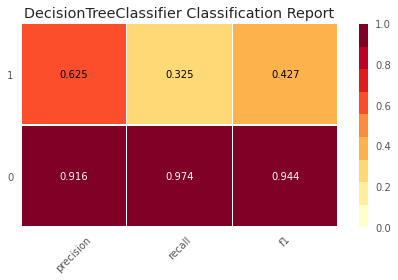

<AxesSubplot:title={'center':'DecisionTreeClassifier Classification Report'}>

In [28]:
viz = ClassificationReport(DecisionTreeClassifier(criterion = "entropy", max_depth=4))
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

Training accuracy 0.8956299175277277

Testing accuracy 0.895532291359481

Confusion Matrix


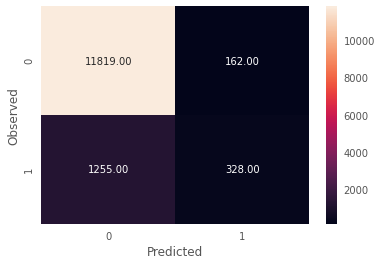

None

Recall: 0.20720151610865445

Precision: 0.6693877551020408

F1 Score: 0.3164495899662325

Roc Auc Score: 0.8942272193126275


In [29]:
# Adaboost

from sklearn.ensemble import AdaBoostClassifier
abcl = AdaBoostClassifier(n_estimators = 100, learning_rate=0.1, random_state=22)
abcl = abcl.fit(X_train, y_train)

y_predict =abcl.predict(X_test)

roc = ROCAUC(AdaBoostClassifier(n_estimators= 100, learning_rate=0.1, random_state=22))
roc.fit(X_train, y_train)

print("Training accuracy", abcl.score(X_train, y_train))  
print()
print("Testing accuracy", abcl.score(X_test, y_test))
print()
print('Confusion Matrix')
print(draw_cm(y_test,y_predict))
print()
print("Recall:",recall_score(y_test,y_predict))
print()
print("Precision:",precision_score(y_test,y_predict))
print()
print("F1 Score:",f1_score(y_test,y_predict))
print()
print("Roc Auc Score:", roc.score(X_test, y_test))

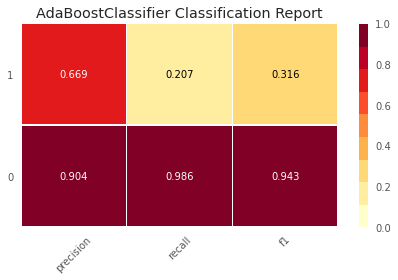

<AxesSubplot:title={'center':'AdaBoostClassifier Classification Report'}>

In [30]:
viz = ClassificationReport(AdaBoostClassifier(n_estimators= 100, learning_rate=0.1, random_state=22))
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

Training accuracy 0.9937434827945777

Testing accuracy 0.9060011795930404

Confusion Matrix


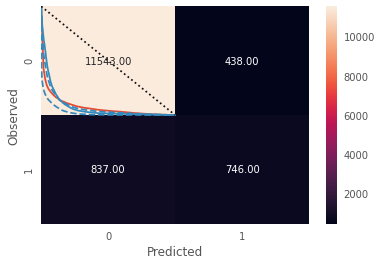

None

Recall: 0.47125710675931776

Precision: 0.6300675675675675

F1 Score: 0.5392121431152872

Roc Auc Score: 0.925315129667035


In [31]:
# Bagging Classifier

from sklearn.ensemble import BaggingClassifier

bgcl = BaggingClassifier(n_estimators=50, max_samples= .7, bootstrap=True, oob_score=True, random_state=22)
bgcl = bgcl.fit(X_train, y_train)

y_predict = bgcl.predict(X_test)

roc = ROCAUC(BaggingClassifier(n_estimators=50, max_samples= .7, bootstrap=True, oob_score=True, random_state=22))
roc.fit(X_train, y_train)
roc.score(X_test, y_test)

print("Training accuracy", bgcl.score(X_train, y_train))  
print()
print("Testing accuracy", bgcl.score(X_test, y_test))
print()
print('Confusion Matrix')
print(draw_cm(y_test,y_predict))
print()
print("Recall:",recall_score(y_test,y_predict))
print()
print("Precision:",precision_score(y_test,y_predict))
print()
print("F1 Score:",f1_score(y_test,y_predict))
print()
print("Roc Auc Score:", roc.score(X_test, y_test))

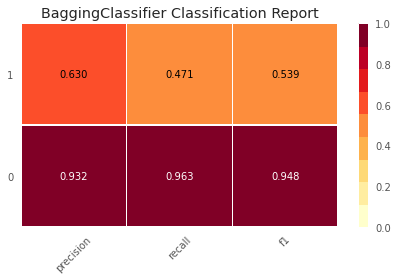

<AxesSubplot:title={'center':'BaggingClassifier Classification Report'}>

In [32]:
viz = ClassificationReport(BaggingClassifier(n_estimators=50, max_samples= .7, bootstrap=True, oob_score=True, random_state=22))
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

Training accuracy 0.9073529876449584

Testing accuracy 0.9041580654674137

Confusion Matrix


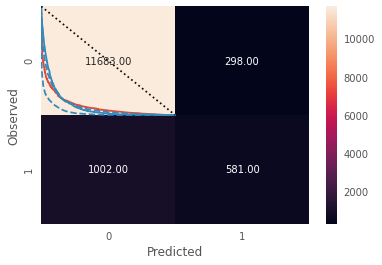

None

Recall: 0.36702463676563485

Precision: 0.6609783845278726

F1 Score: 0.47197400487408614

Roc Auc Score: 0.9170434178914625


In [33]:
# GradientBoost Classifier

from sklearn.ensemble import GradientBoostingClassifier
gbcl = GradientBoostingClassifier(n_estimators = 50, learning_rate = 0.1, random_state=22)
gbcl = gbcl.fit(X_train, y_train)

y_predict = gbcl.predict(X_test)

roc = ROCAUC(GradientBoostingClassifier(n_estimators = 50, learning_rate = 0.1, random_state=22))
roc.fit(X_train, y_train)
roc.score(X_test, y_test)

print("Training accuracy", gbcl.score(X_train, y_train))  
print()
print("Testing accuracy", gbcl.score(X_test, y_test))
print()
print('Confusion Matrix')
print(draw_cm(y_test,y_predict))
print()
print("Recall:",recall_score(y_test,y_predict))
print()
print("Precision:",precision_score(y_test,y_predict))
print()
print("F1 Score:",f1_score(y_test,y_predict))
print()
print("Roc Auc Score:", roc.score(X_test, y_test))

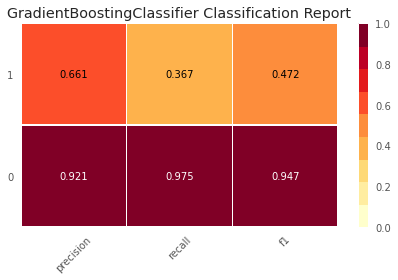

<AxesSubplot:title={'center':'GradientBoostingClassifier Classification Report'}>

In [34]:
viz = ClassificationReport(GradientBoostingClassifier(n_estimators = 50, learning_rate = 0.1, random_state=22))
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

The Bagging Classifier maintains the best recall and testing accuracy. Ultimately we want more clients to subscribe term deposit so we want to decrease false negatives. For these reasons, I would select this algorithm. 